In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder

import pickle

%matplotlib inline

## Load dataset

In [2]:
data = pd.read_csv('CarPrice.csv')
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
data.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

# Explanatory analysis

In [4]:
data.shape

(8128, 13)

In [5]:
data.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

### Remove null values

In [6]:
data = data.dropna(how='any')
data.shape

(7906, 13)

### Extract integer value in torque column

In [7]:
torque = data.torque

In [8]:
pattern = r'(\d+\.\d+|\d+,\d+|\d+)'
torque = torque.str.extractall(pattern)

def convert_to_number(x):
    if ',' in x:
        return int(x.replace(',', ''))
    elif '.' in x:
        return float(x)
    else:
        return int(x)

torque = torque[0].apply(convert_to_number).groupby(level=0).apply(list).tolist()

torque = [max(x) for x in torque]

### Extract integer value in mileage column

In [9]:
mileage = data.mileage
mileage = [float(x.split()[0]) for x in mileage]

### Extract integer value in engine column

In [10]:
engine = data.engine
engine = [int(x.split()[0]) for x in engine]

### Extract integer value in max_power column

In [11]:
max_power = data.max_power
max_power = [float(x.split()[0]) for x in max_power]

### Compute car age

In [12]:
age = [2024-x for x in data.year]

### Get car brand

In [13]:
name = [x.split()[0] for x in data.name]

### Create new column in our dataset

In [14]:
data['torque_rmp'] = torque
data['mileage_kmpl'] = mileage
data['engine_cc'] = engine
data['max_power_bhp'] = max_power
data['age'] = age
data['brand'] = name


In [15]:
data = data.drop(['name', 'year','mileage', 'engine', 'max_power', 'torque', 'owner'], axis=1)
data.head()

,selling_price,km_driven,fuel,seller_type,transmission,seats,torque_rmp,mileage_kmpl,engine_cc,max_power_bhp,age,brand
0,450000,145500,Diesel,Individual,Manual,5.0,2000.0,23.40,1248,74.00,10,Maruti
1,370000,120000,Diesel,Individual,Manual,5.0,2500.0,21.14,1498,103.52,10,Skoda
2,158000,140000,Petrol,Individual,Manual,5.0,2700.0,17.70,1497,78.00,18,Honda
3,225000,127000,Diesel,Individual,Manual,5.0,2750.0,23.00,1396,90.00,14,Hyundai
4,130000,120000,Petrol,Individual,Manual,5.0,4500.0,16.10,1298,88.20,17,Maruti


In [16]:
data.brand.value_counts()

brand
Maruti           2367
Hyundai          1360
Mahindra          758
Tata              719
Honda             466
Toyota            452
Ford              388
Chevrolet         230
Renault           228
Volkswagen        185
BMW               118
Skoda             104
Nissan             81
Jaguar             71
Volvo              67
Datsun             65
Mercedes-Benz      54
Fiat               41
Audi               40
Lexus              34
Jeep               31
Mitsubishi         14
Force               6
Land                6
Isuzu               5
Kia                 4
Ambassador          4
Daewoo              3
MG                  3
Ashok               1
Opel                1
Name: count, dtype: int64

### Deal with class imbalance

In [17]:
threshold = 100
count = data.brand.value_counts()
aggregate = count[count < threshold].index

In [18]:
data['brand'] = data['brand'].apply(lambda x: 'Other' if x in aggregate else x)


In [19]:
data.brand.value_counts()

brand
Maruti        2367
Hyundai       1360
Mahindra       758
Tata           719
Other          531
Honda          466
Toyota         452
Ford           388
Chevrolet      230
Renault        228
Volkswagen     185
BMW            118
Skoda          104
Name: count, dtype: int64

### Encode label

In [20]:
data_copy = data.copy()
label_encoder = LabelEncoder()
cols = ['brand', 'fuel', 'seller_type', 'transmission']
for col in cols:
    data_copy[col] = label_encoder.fit_transform(data[col])

## Visualize the dataset

In [21]:
data_copy.head()

,selling_price,km_driven,fuel,seller_type,transmission,seats,torque_rmp,mileage_kmpl,engine_cc,max_power_bhp,age,brand
0,450000,145500,1,1,1,5.0,2000.0,23.40,1248,74.00,10,6
1,370000,120000,1,1,1,5.0,2500.0,21.14,1498,103.52,10,9
2,158000,140000,3,1,1,5.0,2700.0,17.70,1497,78.00,18,3
3,225000,127000,1,1,1,5.0,2750.0,23.00,1396,90.00,14,4
4,130000,120000,3,1,1,5.0,4500.0,16.10,1298,88.20,17,6


In [22]:
data_copy.describe()

,selling_price,km_driven,fuel,seller_type,transmission,seats,torque_rmp,mileage_kmpl,engine_cc,max_power_bhp,age,brand
count,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,6.498137e+05,6.918866e+04,1.888313,0.889831,0.868328,5.416393,3069.864154,19.419861,1458.708829,91.587374,10.016064,5.906274
std,8.135827e+05,5.679230e+04,1.001478,0.397182,0.338155,0.959208,943.662100,4.036263,503.893057,35.747216,3.863695,2.717376
min,2.999900e+04,1.000000e+00,0.000000,0.000000,0.000000,2.000000,400.000000,0.000000,624.000000,32.800000,4.000000,0.000000
25%,2.700000e+05,3.500000e+04,1.000000,1.000000,1.000000,5.000000,2400.000000,16.780000,1197.000000,68.050000,7.000000,4.000000
50%,4.500000e+05,6.000000e+04,1.000000,1.000000,1.000000,5.000000,3000.000000,19.300000,1248.000000,82.000000,9.000000,6.000000
75%,6.900000e+05,9.542500e+04,3.000000,1.000000,1.000000,5.000000,4000.000000,22.320000,1582.000000,102.000000,12.000000,7.000000
max,1.000000e+07,2.360457e+06,3.000000,2.000000,1.000000,14.000000,21800.000000,42.000000,3604.000000,400.000000,30.000000,12.000000


### Plotting a histogram to visualize the car market in accordance with the dataset.


<Figure size 800x400 with 0 Axes>

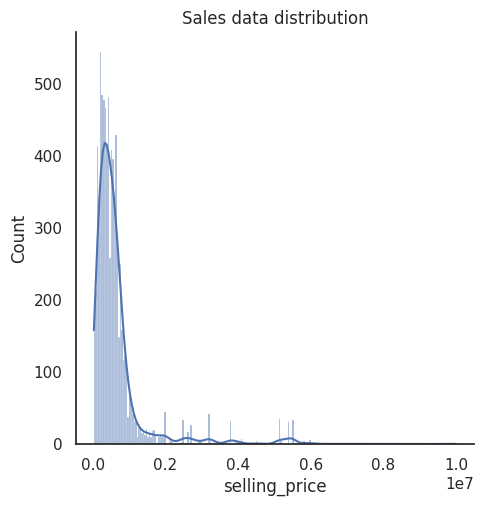

In [50]:
fig=plt.figure(figsize=(8,4))
sns.displot(data_copy['selling_price'], kde=True)
plt.title('Sales data distribution');

### Normalize data

In [23]:
def normalize(col):
    min_ = col.min()
    max_ = col.max()
    return [(x-min_) / (max_ - min_) for x in col]

#### Normalize

In [170]:
for col in data_copy.columns:
    if col == 'selling_price' or col == 'brand':
        pass
    else:
        data_copy[col] = normalize(data_copy[col])

### Plotting a heat map to analyze the data and keep an eye on the co-relation between labels.


<Axes: >

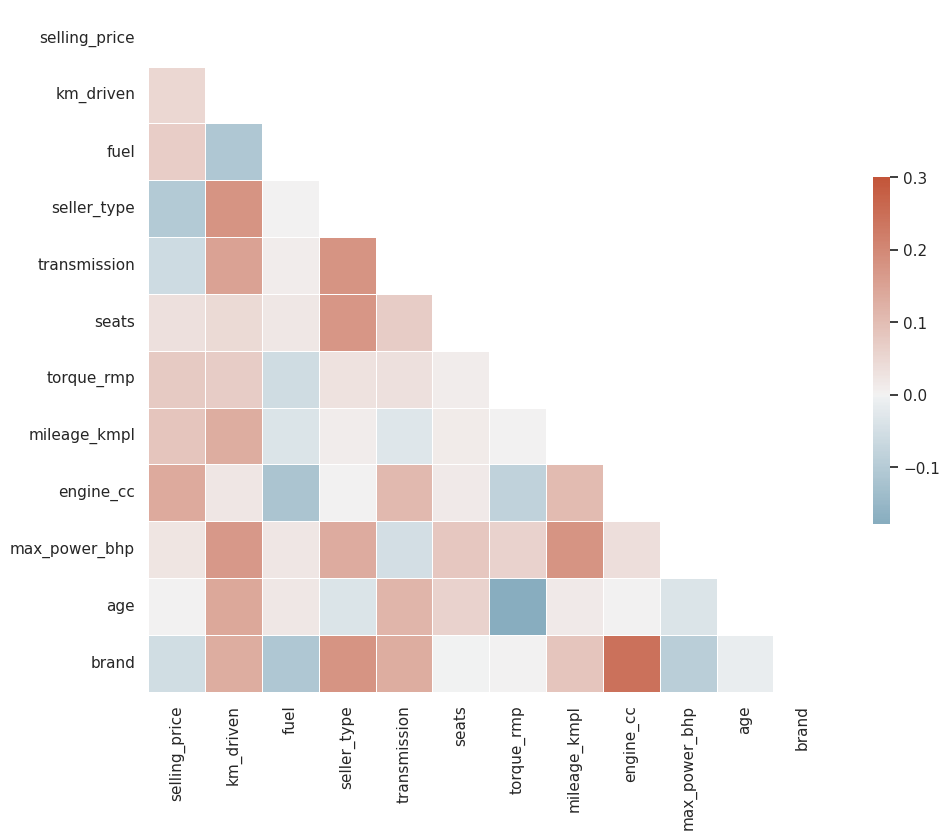

In [27]:
sns.set_theme(style="white")
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 12)),
                 columns=list(data_copy))
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlation matrix

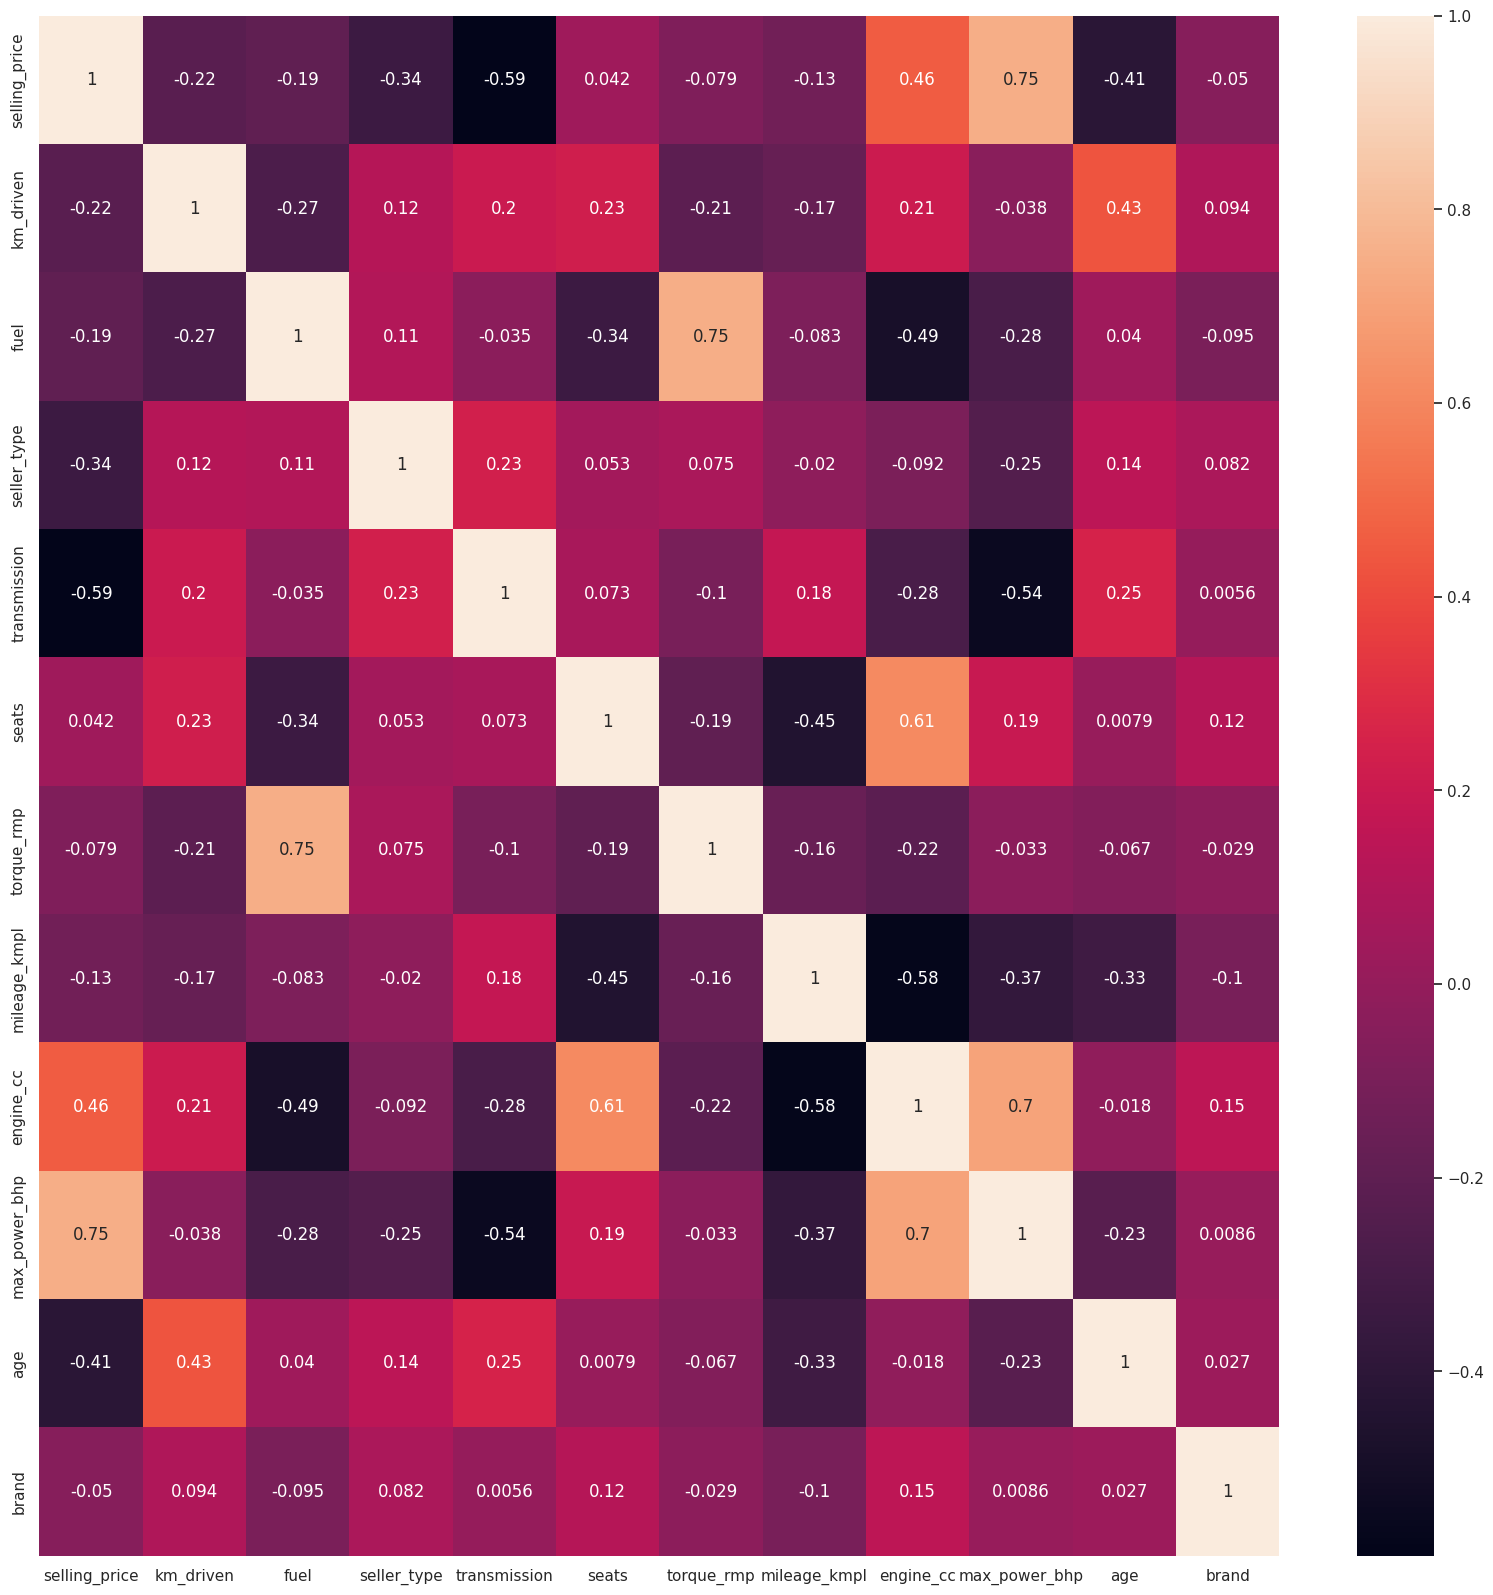

In [30]:
corrmat=data_copy.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data_copy[top_corr_features].corr(),annot=True)

### Machine learning model

#### Split data

In [33]:
Y = data_copy.selling_price
X = data_copy.drop('selling_price', axis=1)

### Finding out the labels that has a much greater impact on the model.

In [34]:
model = ExtraTreesRegressor()
model.fit(X,Y)

ExtraTreesRegressor()

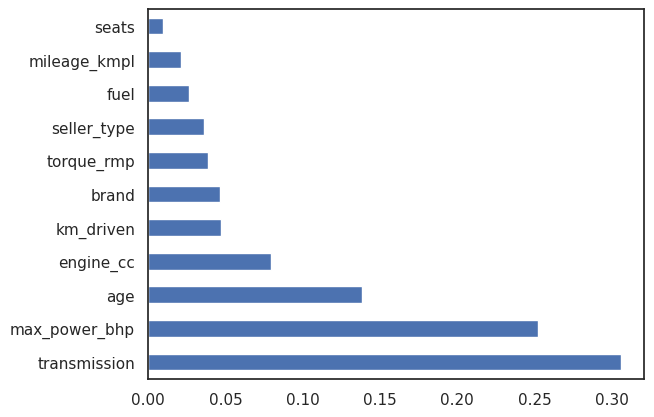

In [37]:
feat_importances=pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(len(X.columns)).plot(kind='barh')
plt.show()

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
RF_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

In [39]:
RF_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [40]:
y_pred = RF_model.predict(X_test)

### Accuracy for test data

In [41]:
acc = round(RF_model.score(X_test, Y_test)*100, 2)
print(f"Test data accuracy is {acc}%")

Test data accuracy is 96.84%


### Plotting grapsh

<Figure size 800x400 with 0 Axes>

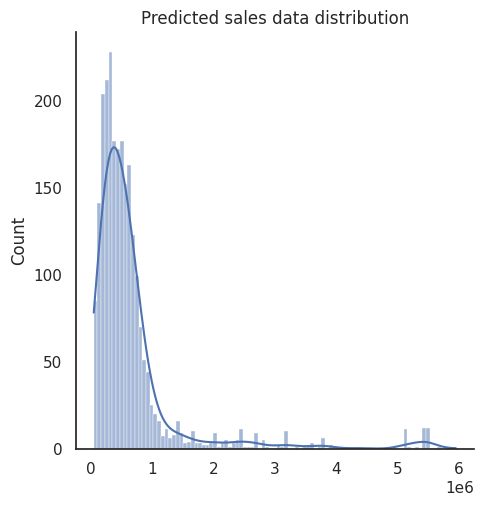

In [51]:
fig=plt.figure(figsize=(8,4))
sns.displot(y_pred, kde=True)
plt.title('Predicted sales data distribution');

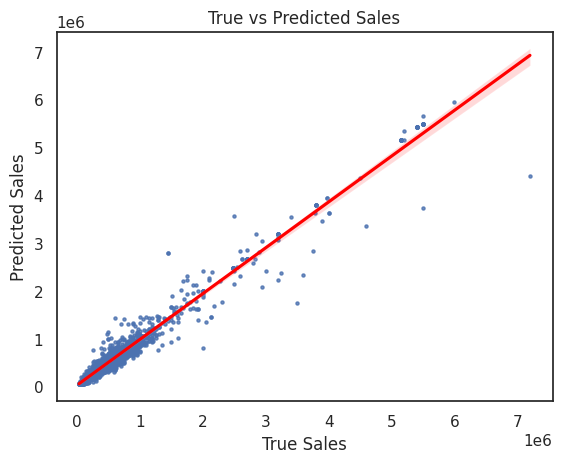

In [56]:
sns.regplot(x=Y_test, y=y_pred, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('True vs Predicted Sales')
plt.show()

### Save the trained model

In [42]:

with open('carprice_model.pkl', 'wb') as file:
    pickle.dump(RF_model, file)
